In [19]:
import sys, os, distutils.core
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0
torch:  2.6 ; cuda:  df5bbc09d1.nv24.12
detectron2: 0.6


In [20]:
import cv2
cv2.__version__

'4.10.0'

In [21]:
import random
import os

from pathlib import Path

import cv2
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn import functional as nnf
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from tqdm import tqdm

import json

def load_json(file_path):
    f = open(file_path)
    json_file = json.load(f)
    f.close()
    
    return json_file

def save2json(dicts_list, target_path, mode="w"):

    print("Writing json file" + "."*50)
    with open(target_path, mode) as f:
        json.dump(dicts_list, f, indent=2)

    print("Done! Json was wrote to {}".format(target_path))

img_root = "/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"


In [22]:
def poly2box(coords, pad=0):

    # for idx, coord in enumerate(coords):
    xs = coords[:, 0]
    ys = coords[:, 1]

    tl = [np.min(xs) - pad, np.min(ys) - pad]
    br = [np.max(xs) + pad, np.max(ys) + pad]

    x_min, y_min = tl[0], tl[1]
    x_max, y_max = br[0], br[1]

    w = x_max - x_min
    h = y_max - y_min

    size = max(w, h)
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2

    half = size / 2
    x1, y1 = int(cx - half), int(cy - half)
    x2, y2 = int(cx + half), int(cy + half)

    box = [
        [x1, y1],
        [x2, y1],
        [x2, y2],
        [x1, y2]
    ]

    return box

In [23]:
def convert2coco(anno_path, img_root, dst_path, clss, cls_dict, patn_id=True):

    imgs = []
    annos = []

    img_idx = 0
    cell_idx = 0

    if isinstance(anno_path, str):
        anno = load_json(anno_path)
    else:
        anno = anno_path

    for imgn, v in tqdm(anno.items()):

        imgn = str(imgn)

        print(imgn)

        imgp = os.path.join(img_root, imgn)

        img = cv2.imread(imgp)

        h, w, _ = img.shape

        labels = v["labels"]
        points = v["points"]

        # img_id = imgn[:-4]

        p_idx = imgn[:7]

        c_imgs = {
            "id": img_idx,
            "file_name": imgn,
            "width": w,
            "height": h
        }

        if patn_id:
            c_imgs["patient_id"] = p_idx

        imgs.append(c_imgs)

        for label, point in zip(labels, points):

            label = int(label)
            point = np.array(point)

            box = poly2box(point, 3)
            
            tl = box[0]
            br = box[2]

            bbox_h = br[-1] - tl[-1]
            bbox_w = br[0] - tl[0]

            c_annos = {
                "id": cell_idx,
                "image_id": img_idx,
                "category_id": cls_dict[label][0],
                "segmentation": [point.flatten().tolist()],
                "bbox": [int(tl[0]), int(tl[1]), bbox_w, bbox_h],
                "is_crowd": 0
            }

            if patn_id:
                c_annos["patient_id"] = p_idx

            annos.append(c_annos)
            cell_idx += 1

        img_idx += 1
        

    coco_style_anno = {
        "images": imgs,
        "annotations": annos,
        "categories": clss
    }

    save2json(coco_style_anno, dst_path)

    return coco_style_anno

In [18]:

clss = [
    {"id":0, "name": "level_0"},
    {"id":1, "name": "level_1"},
    {"id":2, "name": "level_2"},
    {"id":3, "name": "level_3"},
    {"id":4, "name": "level_4"},
]

cls_dict = {
    0: [0, "level_0"],
    1: [1, "level_1"],
    2: [2, "level_2"],
    3: [3, "level_3"],
    4: [4, "level_4"],
}

root_path = "/workspace/datasets/seg_by_patient/anno/only_allergy"

train_anno = os.path.join(root_path, "allergy_train_anno.json")
test_anno = os.path.join(root_path, "allergy_test_anno.json")
all_anno = os.path.join(root_path, "allergy_merge_anno.json")

dst_root = "/workspace/datasets/seg_by_patient/anno/coco_format/only_allergy"
train_dst = os.path.join(dst_root, "allergy_train.json")
test_dst = os.path.join(dst_root, "allergy_test.json")
all_dst = os.path.join(dst_root, "allergy_merge.json")


new_train_anno = convert2coco(train_anno, img_root, train_dst, clss, cls_dict)
new_test_anno = convert2coco(test_anno, img_root, test_dst, clss, cls_dict)
new_all_anno = convert2coco(all_anno, img_root, all_dst, clss, cls_dict)

  0%|          | 0/128 [00:00<?, ?it/s][ WARN:0@6463.233] global loadsave.cpp:241 findDecoder imread_('/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2/raw2_07-(D3)24h-1.JPG'): can't open/read file: check file path/integrity


raw2_07-(D3)24h-1.JPG


AttributeError: 'NoneType' object has no attribute 'shape'

In [6]:
all_anno = "/workspace/datasets/seg_by_patient/anno/merge_anno.json"
anno = load_json(all_anno)

In [9]:
def pad_5_cell(img, val=0, img_size_5=(300, 1200), w_15=600):

    h = img.shape[0]
    w = img.shape[1]

    c = min(img.shape)

    assert_msg = f"Expected img in shape {img_size_5}, received {img.shape}, please resize first."

    assert w == img_size_5[0] and h == img_size_5[1], assert_msg

    # value = [val for _ in range(c)]

    pad_left = pad_right = (w_15-img_size_5[0])//2

    padded_img = cv2.copyMakeBorder(
        img, top=0, bottom=0, 
        left=pad_left, right=pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=val
    )

    return padded_img

def polygon_centroid(polygon):
    moments = cv2.moments(polygon)
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])
    return cx, cy

def sort_15_cells(pnts, labels):
    cxcy = []

    for pol, label in zip(pnts, labels):
        cx, cy = polygon_centroid(pol.astype(np.int32))
        cxcy.append([cx, cy])

    cxcy = np.array(cxcy)

    cy = cxcy[:, 1]
    cx = cxcy[:, 0]

    most_right = max(cx)
    most_left = min(cx)

    w_range = most_right - most_left + 10

    img_q = w_range // 3

    center_cells = {}
    left_cells = {}
    right_cells = {}

    for cxy, pol, label in zip(cxcy, pnts, labels):
        cx, cy = cxy[0], cxy[1]

        if cx-most_left < img_q:
            left_cells[int(cy)] = (pol, label)
        elif cx-most_left > img_q*2:
            right_cells[int(cy)] = (pol, label)
        else:
            center_cells[int(cy)] = (pol, label)

    center_cells = sorted(center_cells.items())
    left_cells = sorted(left_cells.items())
    right_cells = sorted(right_cells.items())

    sorted_polygons = np.zeros((15, 4, 2))
    sorted_labels = np.zeros((15))

    sorted_polygons[:5, :, :] = np.array([i[1][0] for i in center_cells])
    sorted_polygons[5:10, :, :] = np.array([i[1][0] for i in left_cells])
    sorted_polygons[10:15, :, :] = np.array([i[1][0] for i in right_cells])

    sorted_labels = [i[1][1] for i in center_cells] + [i[1][1] for i in right_cells] 
    sorted_labels += [i[1][1] for i in left_cells]
    
    return sorted_polygons, sorted_labels

def mod_5_cell(img, pnts, target_size=(600, 1200)):

    out = []

    h, w, _ = img.shape

    dx = (target_size[0] - w) / 2
    dy = (target_size[1] - h) / 2

    


In [23]:
from tqdm import tqdm

img_root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"

new_dst = Path("/workspace/datasets/skin_patch_img_dataset/all_pos_cropped_patch_all_r1_r2")
new_dst.mkdir(parents=True, exist_ok=True)

new_pos_anno = {}

img_size_5 = (300, 1200)
img_size_15 = (600, 1200)

for k, v in tqdm(anno.items()):
    imgn = k
    points = np.array(v["points"])
    label = v["labels"]

    print(label)
    img_path = Path(img_root) / imgn

    img = cv2.imread(img_path)

    print(img_path)
    print(imgn)
    print(imgn.split("-"))

    nof_cell = 5 if int(imgn.split("-")[2][0]) == 4 else 15

    h, w, _ = img.shape

    new_ps = np.zeros_like(points)

    if nof_cell == 5:
        img = cv2.resize(img, img_size_5)
        img = pad_5_cell(img, 0, img_size_5, img_size_15[0])
        sx = img_size_5[0] / w
        sy = img_size_5[1] / h

        # h, w, _ = img.shape

        dx = (img_size_15[0] - img_size_5[0]) / 2
        dy = (img_size_15[1] - img_size_5[1]) / 2

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 0] += dx

            new_ps[idx, :, 1] = pnt[:, 1] * sy
            new_ps[idx, :, 1] += dy

    else:
        img = cv2.resize(img, img_size_15)
        sx = img_size_15[0] / w
        sy = img_size_15[1] / h

        points, label = sort_15_cells(points, label)

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 1] = pnt[:, 1] * sy

    new_pos_anno[imgn] = {
        "labels": label,
        "points": new_ps.tolist()
    }

    img_dst = new_dst / imgn

    cv2.imwrite(img_dst, img)
    
dst_anno = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/pre_merge.json")
save2json(new_pos_anno, dst_anno)

  0%|          | 0/392 [00:00<?, ?it/s]

['1']
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw2_22-(D3)24h-1.JPG
raw2_22-(D3)24h-1.JPG
['raw2_22', '(D3)24h', '1.JPG']


ValueError: could not broadcast input array from shape (0,) into shape (5,4,2)

In [79]:
from functools import partial

def show_pnts_with_text(img, points, color=(255, 0, 0)):

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1.0
    clr = (255, 0, 0)
    thickness = 2

    put_text = partial(cv2.putText, fontFace=font, fontScale=fontScale, color=clr, thickness=thickness)

    cimg = img.copy()

    radius = 1
    
    thickness = 10
    draw_circle = partial(cv2.circle, radius=radius, color=color, thickness=thickness)

    for idx, square in enumerate(points):
        for pnt in square:
            pnt = pnt.astype(np.int32)
            draw_circle(cimg, pnt)
        cimg = put_text(cimg, str(idx+1), pnt)

    return cimg


In [94]:
ks = list(new_pos_anno.keys())

imgn = ks[3]

a1 = new_pos_anno[imgn]
label = a1["labels"]
pnts = np.array(a1["points"])

# sorted_pnts, sorted_label = sort_15_cells(pnts, label)

a1

{'labels': ['0', '0', '0', '0', '0'],
 'points': [[[261.8055597941081, 118.48341232227489],
   [348.9969126383464, 109.70686058297542],
   [351.3117345174154, 200.98296974507554],
   [261.8055597941081, 209.759521484375]],
  [[274.922841389974, 329.1205962122334],
   [355.9413528442383, 329.1205962122334],
   [359.0277735392253, 424.78498847563685],
   [277.23765055338544, 428.2955802447423]],
  [[278.00926208496094, 578.3745788284953],
   [357.4845631917318, 567.8427456679502],
   [359.7993850708008, 644.1987096415877],
   [277.23765055338544, 651.2199510330273]],
  [[265.66357930501306, 788.1341292394847],
   [351.3117345174154, 787.2564379072868],
   [355.9413528442383, 885.5538173874407],
   [271.0648091634115, 882.9208590973045]],
  [[262.57715861002606, 1016.3243298281991],
   [350.54012298583984, 1011.936162433353],
   [348.9969126383464, 1100.579226525474],
   [267.97840118408203, 1104.9675096267772]]]}

In [89]:
imgn

'raw1_01.D2(30m)-4.JPG'

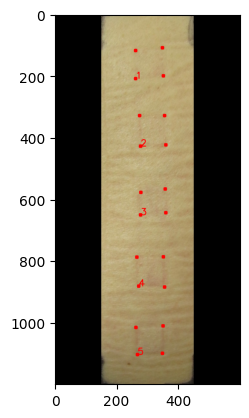

In [95]:
img_path = new_dst / imgn

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, img_size_15)

bbox_img = show_pnts_with_text(img, pnts)

plt.imshow(bbox_img)

In [99]:
ori_anno_root = Path("/workspace/datasets/seg_by_patient/anno")

ac_prefix = "all_complete_"
ori_train_path = ori_anno_root / f"{ac_prefix}train.json"
ori_test_path = ori_anno_root / f"{ac_prefix}test.json"

ori_train = load_json(ori_train_path)
ori_test = load_json(ori_test_path)

pre_ac_anno_root = Path("/workspace/datasets/seg_by_patient/preprocessed/anno")
pre_ac_anno_path = pre_ac_anno_root / "pre_all_complete_merge.json"

pre_ac_anno = load_json(pre_ac_anno_path)

pre_ac_train = {k:pre_ac_anno[k] for k in ori_train}
pre_ac_test = {k:pre_ac_anno[k] for k in ori_test}

print("Train")
print("ori_train:", len(ori_train))
print("pre_ac_train:", len(pre_ac_train))

print("Test")
print("ori_test:", len(ori_test))
print("pre_ac_test:", len(pre_ac_test))

dst_pac_train = pre_ac_anno_root / "pre_all_complete_train.json"
dst_pac_test = pre_ac_anno_root / "pre_all_complete_test.json"

save2json(pre_ac_train, dst_pac_train)
save2json(pre_ac_test, dst_pac_test)


Train
ori_train: 183
pre_ac_train: 183
Test
ori_test: 69
pre_ac_test: 69
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/pre_all_complete_train.json
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/pre_all_complete_test.json


In [38]:
clss = [
    {"id":0, "name": "level_0"},
    {"id":1, "name": "level_1"},
    {"id":2, "name": "level_2"},
    {"id":3, "name": "level_3"},
    {"id":4, "name": "level_4"},
]

cls_dict = {
    0: [0, "level_0"],
    1: [1, "level_1"],
    2: [2, "level_2"],
    3: [3, "level_3"],
    4: [4, "level_4"],
}

pre_ac_root = Path("/workspace/datasets/seg_by_patient/preprocessed/anno")
pre_ac_train = pre_ac_root / "pre_all_complete_train.json"
pre_ac_test = pre_ac_root / "pre_all_complete_test.json"
pre_ac_all = pre_ac_root / "pre_all_complete_merge.json"

coco_dst_all = coco_dst / "all_complete_merge.json"
coco_dst = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format")
coco_dst_train = coco_dst / "pre_all_complete_train.json"
coco_dst_test = coco_dst / "pre_all_complete_test.json"
coco_dst_all = coco_dst / "pre_all_complete_merge.json"

img_root = "/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"
# img_root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"


coco_train_anno = convert2coco(pre_ac_train, img_root, coco_dst_train, clss, cls_dict)
coco_test_anno = convert2coco(pre_ac_test, img_root, coco_dst_test, clss, cls_dict)
coco_all_anno = convert2coco(pre_ac_all, img_root, coco_dst_all, clss, cls_dict)


100%|██████████| 183/183 [00:00<00:00, 287.04it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_train.json


100%|██████████| 69/69 [00:00<00:00, 494.56it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_test.json


100%|██████████| 274/274 [00:00<00:00, 474.41it/s]

Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_merge.json


In [33]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# coco_anno_root = "/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/"
# all_anno = os.path.join(coco_anno_root, "pre_all_complete_merge.json")
# train_anno = os.path.join(coco_anno_root, "pre_all_complete_train.json")
# test_anno = os.path.join(coco_anno_root, "pre_all_complete_test.json")

coco_anno_root = "/workspace/datasets/seg_by_patient/anno/coco_format/"
all_anno = os.path.join(coco_anno_root, "all_complete_merge.json")
train_anno = os.path.join(coco_anno_root, "all_complete_train.json")
test_anno = os.path.join(coco_anno_root, "all_complete_test.json")

# from detectron2.data import DatasetCatalog, MetadataCatalog

# train_dicts = DatasetCatalog.get("train_ds")

# print(train_dicts[0])

DatasetCatalog.remove("train_ds")
MetadataCatalog.remove("train_ds")

DatasetCatalog.remove("test_ds")
MetadataCatalog.remove("test_ds")

DatasetCatalog.remove("all_ds")
MetadataCatalog.remove("all_ds")

register_coco_instances("train_ds", {}, train_anno, img_root)
register_coco_instances("test_ds", {}, test_anno, img_root)
register_coco_instances("all_ds", {}, all_anno, img_root)

# register_coco_instances("train_ds", {}, str(coco_dst_train), img_root)
# register_coco_instances("test_ds", {}, str(coco_dst_test), img_root)
# register_coco_instances("all_ds", {}, str(coco_dst_all), img_root)

train_dicts = DatasetCatalog.get("train_ds")
test_dicts = DatasetCatalog.get("test_ds")
all_dicts = DatasetCatalog.get("all_ds")


print(train_dicts[0])


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.




Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



{'file_name': '/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_01.D2(30m)-1.JPG', 'height': 1236, 'width': 594, 'image_id': 0, 'annotations': [{'bbox': [103, 105, 110, 110], 'category_id': 0, 'segmentation': [[106.25926208496094, 115.68518829345703, 207.1851806640625, 115.68518829345703, 210.88888549804688, 202.72222900390625, 109.96295928955078, 205.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [282, 25, 92, 91], 'category_id': 0, 'segmentation': [[290.5185241699219, 32.35185241699219, 371.0740661621094, 32.35185241699219, 371.0740661621094, 108.27777862548828, 285.8888854980469, 110.12963104248047]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [431, 116, 91, 90], 'category_id': 0, 'segmentation': [[444.22222900390625, 119.38888549804688, 514.5925903320312, 124.01851654052734, 514.5925903320312, 203.6481475830078, 439.59259033203125, 192.5370330810547]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [420, 331, 104, 104], 'category_id': 0, 'segmentation':

In [8]:
import json, os
from collections import Counter

JSON_PATH = all_anno
IM_ROOT   = img_root  # optional, for existence checks

def to_int(x):
    # Coerce "123" -> 123; leave int as-is
    if isinstance(x, str) and x.isdigit():
        return int(x)
    if isinstance(x, (int,)):
        return x
    # try best-effort conversion
    try:
        return int(x)
    except Exception:
        return x

with open(JSON_PATH, "r") as f:
    coco = json.load(f)

images = coco.get("images", [])
anns   = coco.get("annotations", [])
cats   = coco.get("categories", [])

# Build maps
img_id_to_file = {}
img_ids = []
for im in images:
    iid = to_int(im["id"])
    img_id_to_file[iid] = im.get("file_name", f"<no filename for id {iid}>")
    img_ids.append(iid)

img_id_set = set(img_ids)

# 1) List duplicate image ids (also a common cause)
dups = [k for k,v in Counter(img_ids).items() if v>1]
if dups:
    print("❌ Duplicate image ids:", dups)

# 2) Find orphans
orphans = []
bad_type = []
for a in anns:
    ann_id = a.get("id", "<no ann id>")
    iid_raw = a.get("image_id")
    iid = to_int(iid_raw)
    if not isinstance(iid, int):
        bad_type.append((ann_id, iid_raw))
        continue
    if iid not in img_id_set:
        orphans.append((ann_id, iid, img_id_to_file.get(iid, "<missing image>")))

print(f"Images: {len(images)}  Annotations: {len(anns)}")
print(f"Orphan annotations: {len(orphans)}")
if orphans:
    # show a few
    for tup in orphans[:20]:
        print("  ann_id:", tup[0], " image_id:", tup[1], " → filename:", tup[2])

if bad_type:
    print("\n⚠️ Non-numeric image_id found (type mismatch). First few:")
    for ann_id, raw in bad_type[:10]:
        print("  ann_id:", ann_id, " image_id(raw):", raw, " type:", type(raw))

# 3) Optional: check files exist on disk
missing_files = [fn for fn in img_id_to_file.values()
                 if fn and IM_ROOT and not os.path.exists(os.path.join(IM_ROOT, fn))]
if missing_files:
    print("\n⚠️ Missing files on disk (first few):")
    for fn in missing_files[:20]:
        print(" ", fn)


Images: 274  Annotations: 3360
Orphan annotations: 5
  ann_id: 3355  image_id: 274  → filename: <missing image>
  ann_id: 3356  image_id: 274  → filename: <missing image>
  ann_id: 3357  image_id: 274  → filename: <missing image>
  ann_id: 3358  image_id: 274  → filename: <missing image>
  ann_id: 3359  image_id: 274  → filename: <missing image>


In [20]:
import os

root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"
# new_folder = ""


for imgn in os.listdir(root):
    old_path = os.path.join(root, imgn)
    filetype = imgn[-4:]
    imgn = imgn[:-4]
    print(imgn)

    new_filename = imgn.replace(".", "-")
    new_filename = new_filename + filetype

    print(new_filename)

    
    new_path = os.path.join(root, new_filename)

    print(new_path)

# # rename file
    os.rename(old_path, new_path)
# print(f"Renamed to: {new_path}")


raw1_06.D2(30m)-3
raw1_06-D2(30m)-3.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_06-D2(30m)-3.JPG
raw2_22.D2(30m)-4
raw2_22-D2(30m)-4.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw2_22-D2(30m)-4.JPG
raw2_16.D2(30m)-2
raw2_16-D2(30m)-2.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw2_16-D2(30m)-2.JPG
raw1_05.D3(24h)-4
raw1_05-D3(24h)-4.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_05-D3(24h)-4.JPG
raw1_16.D2(30m)-1
raw1_16-D2(30m)-1.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_16-D2(30m)-1.JPG
raw1_25.D3(24h)-3
raw1_25-D3(24h)-3.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_25-D3(24h)-3.JPG
raw2_07.D2(30m)-1
raw2_07-D2(30m)-1.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw2_07-D2(30m)-1.JPG
raw2_18.D2(30m)-4
raw2_18-D2(30m)-4.JPG
/workspace/datasets/skin_patch_img_dataset/cropped_patch_

In [ ]:
def get_only_pos(anno_path, img_root, dst_path, clss, cls_dict, patn_id=True):

    imgs = []
    annos = []

    img_idx = 0

    anno = load_json(anno_path)

    for imgn, v in tqdm(anno.items):
        imgn = str(imgn)

        print(imgn)

        imgp = os.path.join(img_root, imgn)

        img = cv2.imread(imgp)

        h, w, _ = img.shape

        labels = v["labels"]
        points = v["points"]

        p_idx = imgn[:7]

        c_imgs = {
            "id": img_idx,
            "file_name": imgn,
            "width": w,
            "height": h
        }

        if patn_id:
            c_imgs["patient_id"] = p_idx

        imgs.append(c_imgs)

In [7]:
img_root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"
img_path = os.path.join(img_root, "raw2_22-(D3)24h-1.JPG")

img = cv2.imread(img_path)

In [9]:
len(os.listdir("/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"))

274

In [10]:
len(os.listdir("/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"))

527

In [15]:
img_root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"
anno = load_json("/workspace/datasets/skin_patch_img_dataset/anno/segmentation/all_seg/all_seg_anno.json")

new_dst = Path("//workspace/datasets/seg_by_patient/preprocessed/new_pos_cropped_patch_all_r1_r2")
new_dst.mkdir(parents=True, exist_ok=True)

new_pos_anno = {}

img_size_5 = (300, 1200)
img_size_15 = (600, 1200)

for k, v in tqdm(anno.items()):
    imgn = k

    points = []
    label = []

    for (l, p) in zip(v["labels"], v["points"]):
        l = int(l)

        if l > 0:
            points.append(p)
            label.append(l)
    
    if len(label) == 0:
        continue

    points = np.array(points)

    # pp = [i["points"] for i in kv["shapes"]]
    # print(pp)

    # points = np.array([i["points"] for i in kv["shapes"]])
    # label = [i["label"] for i in kv["shapes"]] #v["labels"]

    img_path = Path(img_root) / imgn

    img = cv2.imread(img_path)

    nof_cell = 5 if int(imgn.split("-")[2][0]) == 4 else 15

    h, w, _ = img.shape

    new_ps = np.zeros_like(points)

    if nof_cell == 5:
        img = cv2.resize(img, img_size_5)
        img = pad_5_cell(img, 0, img_size_5, img_size_15[0])
        sx = img_size_5[0] / w
        sy = img_size_5[1] / h

        # h, w, _ = img.shape

        dx = (img_size_15[0] - img_size_5[0]) / 2
        dy = (img_size_15[1] - img_size_5[1]) / 2

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 0] += dx

            new_ps[idx, :, 1] = pnt[:, 1] * sy
            new_ps[idx, :, 1] += dy

    else:
        img = cv2.resize(img, img_size_15)
        sx = img_size_15[0] / w
        sy = img_size_15[1] / h

        # points, label = sort_15_cells(points, label)

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 1] = pnt[:, 1] * sy

    # pos_label = []
    # pos_points = []

    # for l, p in enumerate(zip(label, new_ps.tolist())):
    #     if l > 0:
    #         pos_label.append(l)
    #         pos_points.append(p)

    # label = pos_label
    # new_ps = pos_points

    new_pos_anno[imgn] = {
        "labels": label,
        "points": new_ps.tolist()
    }

    img_dst = new_dst / imgn

    cv2.imwrite(img_dst, img)

dst_anno = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_merge.json")
save2json(new_pos_anno, dst_anno)

100%|██████████| 421/421 [00:01<00:00, 337.67it/s]

Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_merge.json


In [25]:
new_pos_anno = load_json("/workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_merge.json")

new_pos_anno

{'raw1_01-D3(24h)-3.JPG': {'labels': [1],
  'points': [[[69.16421979865773, 820.905172413793],
    [150.17302852348996, 831.6810344827586],
    [158.8244546979866, 903.5201149425287],
    [80.17512583892618, 915.1939655172413]]]},
 'raw1_01-D3(24h)-4.JPG': {'labels': [1],
  'points': [[[260.4936079545455, 1040.0143678160919],
    [362.58877840909093, 1041.810344827586],
    [364.3643465909091, 1128.0172413793102],
    [263.15696022727275, 1135.2011494252872]]]},
 'raw1_02-D2(30m)-2.JPG': {'labels': [1, 1, 1, 1],
  'points': [[[400.5622837370242, 823.7847222222223],
    [499.5025951557093, 821.1805555555555],
    [497.06963667820065, 914.0625],
    [408.6721453287197, 914.0625]],
   [[405.4282006920415, 1041.6666666666667],
    [491.3927335640138, 1036.4583333333335],
    [485.71583044982697, 1114.5833333333335],
    [415.1600346020761, 1119.7916666666667]],
   [[73.73486159169549, 122.39583333333334],
    [156.4554498269896, 114.58333333333334],
    [162.13235294117646, 203.99305555555

In [32]:
ptn_cnt = {k[:7]:0 for k in new_pos_anno}
c1_cnt = {k[:7]:0 for k in new_pos_anno}
c2_cnt = {k[:7]:0 for k in new_pos_anno}

for k, v in new_pos_anno.items():
    ptn = k[:7]
    c1 = v["labels"].count(1)
    c2 = v["labels"].count(2)
    cs = c1 + c2

    ptn_cnt[ptn] += cs
    c1_cnt[ptn] += c1
    c2_cnt[ptn] += c2

ptn_cnt = dict(sorted(ptn_cnt.items(), key=lambda item: item[1]))
for p, v in ptn_cnt.items():
    print(p, v)

raw1_23 1
raw1_24 1
raw1_27 1
raw2_05 1
raw2_10 1
raw2_22 1
raw2_30 1
raw1_01 2
raw1_05 2
raw1_07 2
raw1_14 2
raw1_16 2
raw1_22 2
raw1_31 2
raw2_03 2
raw1_10 3
raw1_11 3
raw1_12 3
raw1_25 3
raw1_30 3
raw2_04 3
raw2_16 3
raw2_23 3
raw2_32 3
raw1_04 4
raw1_15 4
raw1_18 4
raw2_12 4
raw2_21 4
raw2_31 4
raw1_19 5
raw2_11 5
raw2_14 5
raw2_18 5
raw2_24 5
raw1_03 6
raw1_13 6
raw1_17 6
raw1_32 6
raw2_07 6
raw2_08 6
raw2_13 6
raw1_20 7
raw2_19 7
raw2_25 7
raw2_26 7
raw2_02 8
raw2_15 8
raw2_27 8
raw2_28 8
raw2_29 8
raw1_28 9
raw1_33 9
raw2_20 9
raw2_06 10
raw1_02 11
raw1_09 12
raw2_17 13
raw2_09 14
raw2_33 18


In [34]:
print(len(ptn_cnt))

print(len(ptn_cnt) * 0.3)

60
18.0


In [38]:
test_ptn = ["raw1_23","raw1_24","raw1_01","raw1_05","raw1_11","raw1_15",
            "raw1_18","raw1_19","raw2_11","raw1_03","raw1_13","raw1_20",
            "raw2_19","raw2_02","raw2_15","raw2_20","raw2_06", "raw2_17"]

train_ptn = [i for i in ptn_cnt if i not in test_ptn]

print(len(train_ptn))
print(len(test_ptn))

42
18


In [40]:
new_train_anno = {}
new_test_anno = {}


for k, v in new_pos_anno.items():
    ptn = k[:7]

    if ptn in test_ptn:
        new_test_anno[k] = v
    
    elif ptn in train_ptn:
        new_train_anno[k] = v

In [41]:
print(len(new_pos_anno))

print(len(new_train_anno))
print(len(new_test_anno))


213
141
72


In [42]:
dst_train = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_train.json")
dst_test = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_test.json")


save2json(new_train_anno, dst_train)
save2json(new_test_anno, dst_test)

Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_train.json
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/only_allergy/pre_allergy_test.json


In [27]:
ptn_cnt = {k[:7]:0 for k in new_pos_anno}

ptn_cnt

{'raw1_01': 0,
 'raw1_02': 0,
 'raw1_03': 0,
 'raw1_04': 0,
 'raw1_05': 0,
 'raw1_07': 0,
 'raw1_09': 0,
 'raw1_10': 0,
 'raw1_11': 0,
 'raw1_12': 0,
 'raw1_13': 0,
 'raw1_14': 0,
 'raw1_15': 0,
 'raw1_16': 0,
 'raw1_17': 0,
 'raw1_18': 0,
 'raw1_19': 0,
 'raw1_20': 0,
 'raw1_22': 0,
 'raw1_23': 0,
 'raw1_24': 0,
 'raw1_25': 0,
 'raw1_27': 0,
 'raw1_28': 0,
 'raw1_30': 0,
 'raw1_31': 0,
 'raw1_32': 0,
 'raw1_33': 0,
 'raw2_02': 0,
 'raw2_03': 0,
 'raw2_04': 0,
 'raw2_05': 0,
 'raw2_06': 0,
 'raw2_07': 0,
 'raw2_08': 0,
 'raw2_09': 0,
 'raw2_10': 0,
 'raw2_11': 0,
 'raw2_12': 0,
 'raw2_13': 0,
 'raw2_14': 0,
 'raw2_15': 0,
 'raw2_16': 0,
 'raw2_17': 0,
 'raw2_18': 0,
 'raw2_19': 0,
 'raw2_20': 0,
 'raw2_21': 0,
 'raw2_22': 0,
 'raw2_23': 0,
 'raw2_24': 0,
 'raw2_25': 0,
 'raw2_26': 0,
 'raw2_27': 0,
 'raw2_28': 0,
 'raw2_29': 0,
 'raw2_30': 0,
 'raw2_31': 0,
 'raw2_32': 0,
 'raw2_33': 0}

In [43]:
target_train = "/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/only_allergy/pre_allergy_train.json"
target_test = "/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/only_allergy/pre_allergy_test.json"

img_root = "/workspace/datasets/seg_by_patient/preprocessed/new_pos_cropped_patch_all_r1_r2"


clss = [
    {"id":1, "name": "level_1"},
    {"id":2, "name": "level_2"},
    # {"id":3, "name": "level_3"},
    # {"id":4, "name": "level_4"},
]

cls_dict = {
    # 0: [0, "level_0"],
    1: [1, "level_1"],
    2: [2, "level_2"],
    # 3: [3, "level_3"],
    # 4: [4, "level_4"],
}

# new_all_anno = convert2coco(new_pos_anno, img_root, target, clss, cls_dict)
new_train_anno = convert2coco(new_train_anno, img_root, target_train, clss, cls_dict)
new_test_anno = convert2coco(new_test_anno, img_root, target_test, clss, cls_dict)



 45%|████▍     | 63/141 [00:00<00:00, 619.83it/s]

raw1_02-D2(30m)-2.JPG
raw1_02-D2(30m)-3.JPG
raw1_02-D2(30m)-4.JPG
raw1_02-D3(24h)-1.JPG
raw1_02-D3(24h)-2.JPG
raw1_02-D3(24h)-3.JPG
raw1_02-D3(24h)-4.JPG
raw1_04-D2(30m)-2.JPG
raw1_04-D2(30m)-3.JPG
raw1_04-D3(24h)-4.JPG
raw1_07-D3(24h)-3.JPG
raw1_07-D3(24h)-4.JPG
raw1_09-D2(30m)-1.JPG
raw1_09-D2(30m)-2.JPG
raw1_09-D2(30m)-3.JPG
raw1_09-D3(24h)-2.JPG
raw1_09-D3(24h)-3.JPG
raw1_09-D3(24h)-4.JPG
raw1_10-D2(30m)-2.JPG
raw1_10-D2(30m)-3.JPG
raw1_10-D2(30m)-4.JPG
raw1_12-D3(24h)-1.JPG
raw1_12-D3(24h)-2.JPG
raw1_14-D2(30m)-3.JPG
raw1_16-D2(30m)-2.JPG
raw1_16-D3(24h)-4.JPG
raw1_17-D3(24h)-2.JPG
raw1_17-D3(24h)-3.JPG
raw1_17-D3(24h)-4.JPG
raw1_22-D3(24h)-3.JPG
raw1_22-D3(24h)-4.JPG
raw1_25-D2(30m)-2.JPG
raw1_25-D2(30m)-3.JPG
raw1_27-D3(24h)-4.JPG
raw1_28-D2(30m)-3.JPG
raw1_28-D3(24h)-1.JPG
raw1_28-D3(24h)-3.JPG
raw1_28-D3(24h)-4.JPG
raw1_30-D3(24h)-1.JPG
raw1_30-D3(24h)-3.JPG
raw1_30-D3(24h)-4.JPG
raw1_31-D3(24h)-3.JPG
raw1_31-D3(24h)-4.JPG
raw1_32-D3(24h)-1.JPG
raw1_32-D3(24h)-3.JPG
raw1_32-D3

100%|██████████| 141/141 [00:00<00:00, 607.84it/s]


raw2_29-D2(30m)-2.JPG
raw2_29-D2(30m)-3.JPG
raw2_29-D2(30m)-4.JPG
raw2_30-(D3)24h-2.JPG
raw2_31-(D3)24h-1.JPG
raw2_31-(D3)24h-2.JPG
raw2_31-D2(30m)-1.JPG
raw2_31-D2(30m)-2.JPG
raw2_32-(D3)24h-2.JPG
raw2_32-D2(30m)-2.JPG
raw2_33-(D3)24h-1.JPG
raw2_33-(D3)24h-2.JPG
raw2_33-(D3)24h-3.JPG
raw2_33-(D3)24h-4.JPG
raw2_33-D2(30m)-1.JPG
raw2_33-D2(30m)-2.JPG
raw2_33-D2(30m)-3.JPG
raw2_33-D2(30m)-4.JPG
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/only_allergy/pre_allergy_train.json


100%|██████████| 72/72 [00:00<00:00, 616.15it/s]

raw1_01-D3(24h)-3.JPG
raw1_01-D3(24h)-4.JPG
raw1_03-D2(30m)-2.JPG
raw1_03-D2(30m)-3.JPG
raw1_03-D2(30m)-4.JPG
raw1_03-D3(24h)-3.JPG
raw1_03-D3(24h)-4.JPG
raw1_05-D2(30m)-3.JPG
raw1_05-D3(24h)-4.JPG
raw1_11-D3(24h)-3.JPG
raw1_11-D3(24h)-4.JPG
raw1_13-D3(24h)-1.JPG
raw1_13-D3(24h)-2.JPG
raw1_13-D3(24h)-3.JPG
raw1_13-D3(24h)-4.JPG
raw1_15-D2(30m)-1.JPG
raw1_15-D2(30m)-2.JPG
raw1_15-D3(24h)-3.JPG
raw1_15-D3(24h)-4.JPG
raw1_18-D2(30m)-1.JPG
raw1_18-D2(30m)-3.JPG
raw1_18-D2(30m)-4.JPG
raw1_18-D3(24h)-4.JPG
raw1_19-D2(30m)-1.JPG
raw1_19-D2(30m)-2.JPG
raw1_19-D3(24h)-4.JPG
raw1_20-D2(30m)-2.JPG
raw1_20-D2(30m)-3.JPG
raw1_20-D2(30m)-4.JPG
raw1_20-D3(24h)-1.JPG
raw1_20-D3(24h)-2.JPG
raw1_20-D3(24h)-3.JPG
raw1_20-D3(24h)-4.JPG
raw1_23-D3(24h)-4.JPG
raw1_24-D3(24h)-4.JPG
raw2_02-(D3)24h-1.JPG
raw2_02-(D3)24h-2.JPG
raw2_02-(D3)24h-3.JPG
raw2_02-(D3)24h-4.JPG
raw2_02-D2(30m)-1.JPG
raw2_02-D2(30m)-2.JPG
raw2_02-D2(30m)-3.JPG
raw2_06-(D3)24h-1.JPG
raw2_06-(D3)24h-2.JPG
raw2_06-(D3)24h-3.JPG
raw2_06-(D

In [18]:
len(new_pos_anno)

213

In [44]:
len(os.listdir("/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"))


274

In [45]:
len(os.listdir("/workspace/datasets/seg_by_patient/preprocessed/new_pos_cropped_patch_all_r1_r2"))

421